# $$GLMM:~Modelos ~Multiníveis(HLM2)$$

### $$Conceito:$$


São modelos que reconhecem a existência de **estrutura multinível ou hierárquica nos dados**



**Modelo GLM derivam do modelo GLMM**, portanto qualquer modelo GLM pode ser implantado no GLMM caso tenha níveis


**GLMM** Captura o comportamento Heterocedastico (Efeitos Aleatórios) e Multicolineares (Efeitos Fixos) das variáveis


Caso não tenho grupos definidos para analise multinível , pode fazer uma **análise de cluster para encontrar os grupos**


**Variáveis dummies** só mudam o intercepto, não leva em consideração a inclinação da reta



### $$Sinonimos~de~modelos~ GLMM:$$

- **Mixed Models**
- **GLLAMM (Latent)**
- **Hierárquicos (HLM)**
- **Nested Moedels (Aninhados)**
- **RCM (Random Coefficients Modeling)**



### $$Variância~dos~Termos~ Aleatórios:$$


Se as variâncias dos termos aleatórios de **intercepto ou inclinação** forem estatisticamente **diferentes de zero**, procedimentos tradicionais de estimação dos **parâmetros do modelo (OLS)**, como **mínimos quadrados ordinários, não serão adequados**



### $$Dummies:$$


Apenas a inserção de dummies de grupo não capturaria os efeitos de inclinação e sim apenas os efeitos de intercepto, de modo que não permitiria que se separassem os efeitos observáveis (Variáveis explicativas) dos não observáveis (Variáveis latentes), caso não tenha grupos diretamente observaveis sobre a variável dependente



### $$Estratégia~ Step-Up:$$


- **Não existe Step-wise para extrair parâmetros nos modelos Multiníveis, temos que fazer o passo a passo(Step-Up), inserindo estágios de efeitos aleatórios a cada modelagem:**


- **1° Modelo nulo** = Analisa se há efeito aleatório no intercepto, nível 1 variável target, nível 2 variável que pode dar aleatoriedade no intercepto


- **2° Modelo com Interceptos aleatórios** = Sabendo que existe efeitos aleatórios no intercepto(Nível 2), adicionamos variáveis no nível 1 para saber se existe efeitos aleatórios de inclinação no nível 2


- **3° Modelos com Interceptos e Inclinações aleatórias** = Agora que já sabemos que existe aleatoriedade tanto no intercepto quanto na inclinação, adicionamos variável/s de efeito aleatório de inclinação no nível 2


- **4° Demais Modelos** = Ir adicionando variáveis no nível 1 ou nível 2 e verificar se são estatisticamente significantes para a modelagem
















__------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------__


__------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------__

## $$Objetivo:$$  

## $$Criar~o~modelo~Multinível(HLM2)$$$$ ~e ~comparar~com~o~modelo~OLS$$

__------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------__


__------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------__

In [1]:
#Pacotes
import multilevel_py
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# Banco de dados 

In [2]:
# Carregando o dataset
dados = pd.read_csv('estudante_escola.csv',encoding='latin1',sep=',')
dados = dados.set_index('estudante')
x = dados[['escola','horas','texp']]
y = dados.desempenho
dados

,escola,desempenho,horas,texp
estudante,,,,
1,1,25.0,11,3.6
2,1,52.0,23,3.6
3,1,52.0,25,3.6
4,1,30.0,14,3.6
5,1,51.0,24,3.6
...,...,...,...,...
354,10,46.5,28,3.9
355,10,21.0,9,3.9
356,10,42.0,27,3.9


**Tabela com 358 observações e 4 variáveis**

# $$Dicionário~ de~ Dados~ das~ Variáveis$$ 

### **$$Variáveis:$$**


- **estudante:** Número de estudantes 


- **escola:** Número de escolas, cada número representa uma escola diferente

    
- **desempenho:** Nota do aluno no vestibular, de 0 a 100
    

- **horas:** Quantidade de horas que o aluno estudou por semana em média no último ano
    
    
- **texp:** Tempo médio de experiencia dos professores nas escolas



# Análise Exploratória

In [3]:
#Info da tabela
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358 entries, 1 to 358
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   escola      358 non-null    int64  
 1   desempenho  358 non-null    float64
 2   horas       358 non-null    int64  
 3   texp        358 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 14.0 KB


**Todas as variáveis são Quantitativas**

In [4]:
# Estatistica descritivas(Variáveis numericas)
dados[['desempenho','horas','texp']].describe()

,desempenho,horas,texp
count,358.000000,358.000000,358.000000
mean,41.554190,18.997207,5.161173
std,23.225896,6.368910,3.682676
min,6.500000,4.000000,1.900000
25%,21.000000,14.000000,1.900000
50%,35.500000,20.000000,3.600000
75%,59.000000,24.000000,7.500000
max,100.000000,31.000000,13.000000


**Observe que a variável resposta (desempenho) tem uma grande variância nos dados, podemos notar através do desvio padrão**

In [5]:
# Analise da variável Categorica('escola')
dados['escola'].value_counts(ascending=False)

3     48
5     48
1     47
9     44
8     35
10    33
6     30
7     28
2     25
4     20
Name: escola, dtype: int64

**Note que há um desbalanceamento entre o total de escolas, porém para perspectiva multinível acima de 3 dados na variável qualitativa (nível 2) que neste caso seria a variável 'escola' já seria possível a modelagem**

In [6]:
#Desempenho médio dos estudantes por escola
desemp= pd.DataFrame(dados.groupby('escola').desempenho.mean())
desemp.columns = ['Desempenho Medio']
desemp

,Desempenho Medio
escola,
1,36.765957
2,21.400000
3,67.125000
4,55.325000
5,19.270833
6,33.966667
7,57.532143
8,75.428571
9,18.556818


**Há diferença no desempenho médio dos alunos levando em consideração a escola**

**Questões para insights:** 

- **Qual a razão da escola 8 estar com média boa no desempenho dos alunos?**


- **Porque a escola 9 está com uma média ruim? Será a variável 'texp'(tempo de experiencia dos professores) tem influência nesta nota?**


- **A variável 'horas' tem influência no desempenho dos alunos?**


## Análise das variáveis

### Escola X Desempenho

- Analise da variável Target (desempenho) VS Variável preditora (desempenho) nivel 2 (perspectiva multinível)

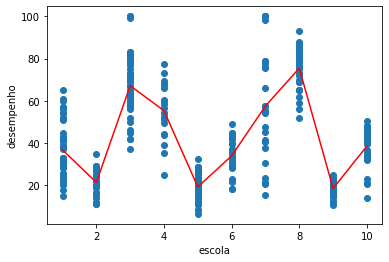

In [7]:
#Exploração visual do desempenho médio dos aluno para cada escola
import matplotlib.pyplot as plt
plt.scatter(dados.escola, dados.desempenho)
plt.plot(desemp['Desempenho Medio'],c='red')
plt.xlabel('escola')
plt.ylabel('desempenho')
plt.show()


**Observe que dependendo da escola, o desempenho da nota do aluno pode mudar**

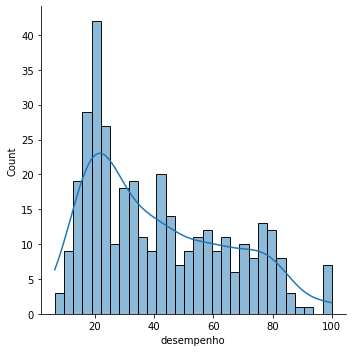

In [8]:
#Kernel density estimation (KDE) - função densidade de probabilidade da variável dependente (desempenho), com histograma
import seaborn as sns
sns.displot(dados.desempenho,kde=True,bins=30);

**Histograma da função densidade de probabilidade de toda base de dados, note que os dados não tem aderência a normalidade**

(0.0, 110.0)

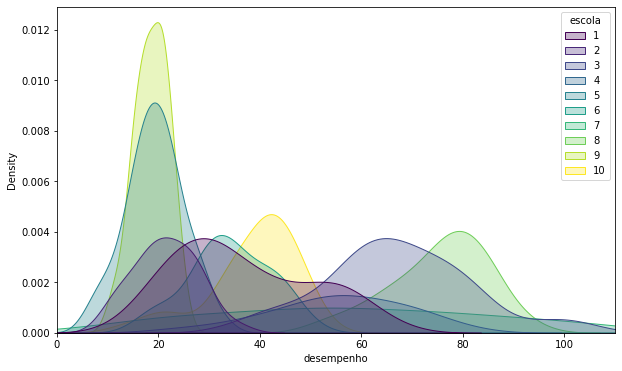

In [9]:
#Kernel density estimation (KDE) - função densidade de probabilidade da variável dependente (desempenho) por escola
from matplotlib import pyplot


fig, ax = pyplot.subplots(figsize=(10, 6))
sns.kdeplot(data=dados, x="desempenho", hue="escola",fill='escola',palette="viridis",alpha=.3,ax=ax)
plt.xlim(0, 110)

**De forma ampla os dados não são aderentes a normalidade, porém de forma individual pode ser que sejam, analisando por escolas (Perspectiva multinível)**

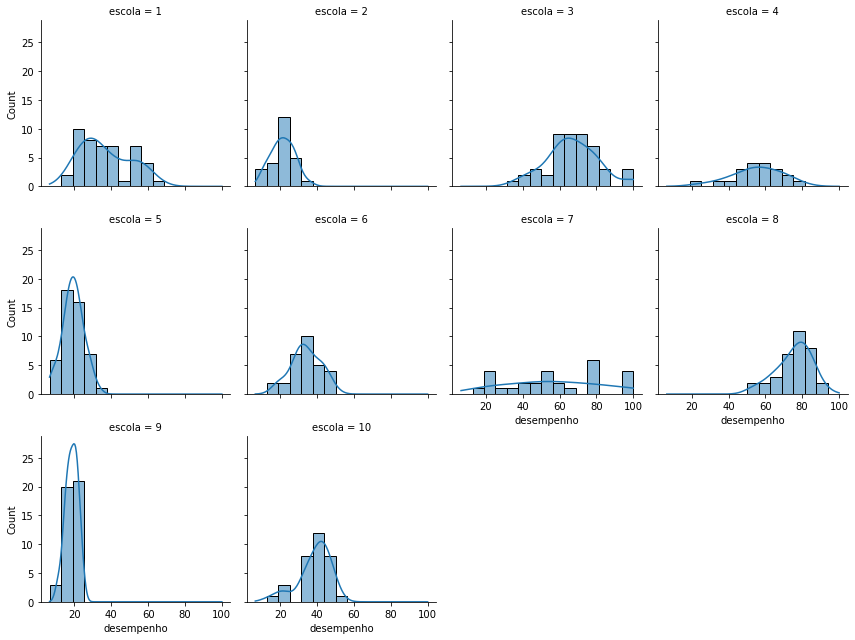

In [10]:
#Histograma individual do desempenho por escola
sns.displot(dados, x="desempenho", col="escola",kde=True,bins=15,col_wrap=4, height=3)


**Distribuição dos dados de cada uma das escolas com a variável target (Desempenho)** 

## Conclusão dos gráficos:

**Note que visualmente há uma diferença no desempenho dos alunos por escola**

**As escolas 2, 5 e 9 tem os piores desempenhos, já as escolas de número 8 e 3 tem os melhores desempenho**

## Desempenho x Horas

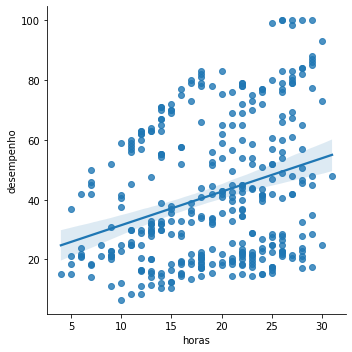

In [11]:
#Gráfico de desempenho x horas (OLS)
sns.lmplot(x="horas", y="desempenho", data=dados)

**Regressão linear não é o ideal para esse conjunto de dados, uma possível solução caso não tivesse uma variável qualitativa que representasse níveis, seria primeiro clusterizar os dados e depois fazer uma OLS para cada cluster, veja o modelo no gráfico abaixo**

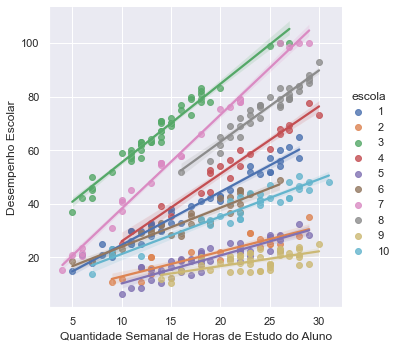

In [12]:
#Gráfico de desempenho x horas por escola (visualização do contexto)
import seaborn as sns; sns.set_theme(color_codes=True)
ax = sns.lmplot(x="horas", y="desempenho", hue="escola", data=dados)
ax.set(xlabel="Quantidade Semanal de Horas de Estudo do Aluno", ylabel="Desempenho Escolar")

**Clusterizamos os dados através da variável 'escola', veja que agora os resíduos são bem menores**

**OBS: NOTE QUE A PERSPECTIVA MULTINÍVEL NATURALMENTE CONSIDERA O COMPORTAMENTO HETEROCEDÁSTICO NOS DADOS**

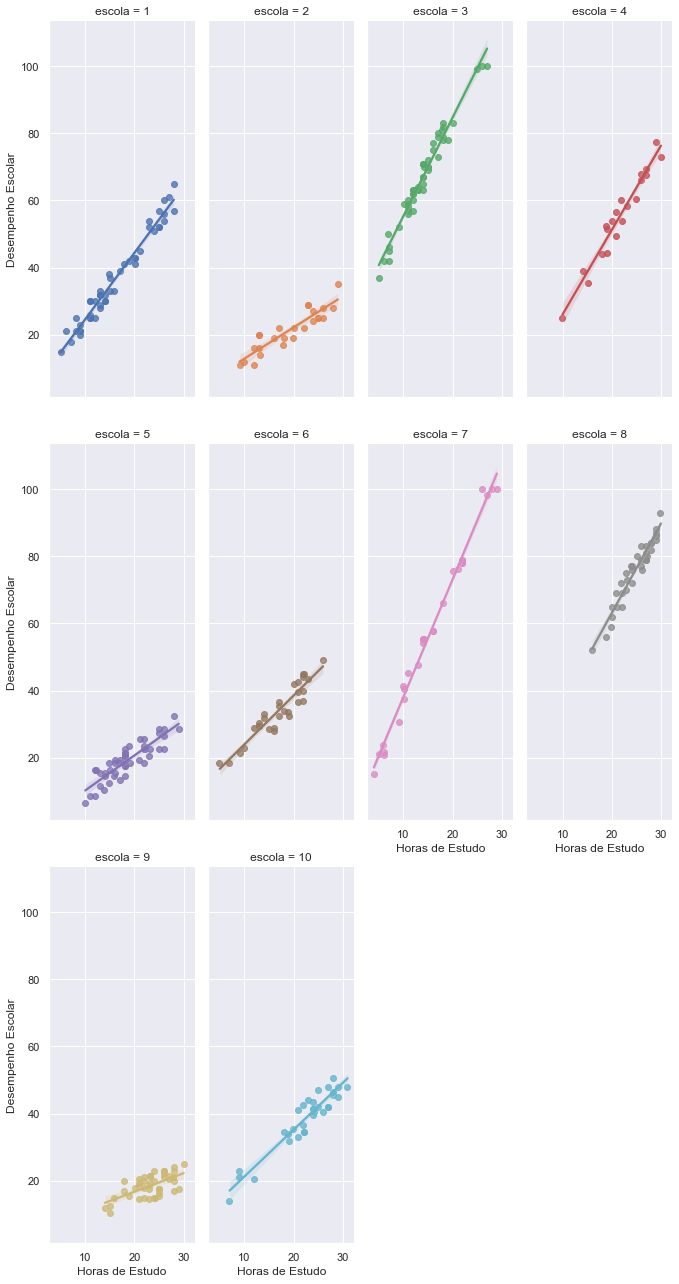

In [13]:
#Gráfico de Hora de estudo X desempenho por escola (visualização do contexto)
ax = sns.lmplot(x="horas", y="desempenho", hue="escola", col="escola",
               data=dados, height=6, aspect=.4, x_jitter=.1,col_wrap=4)
ax.set(xlabel="Horas de Estudo", ylabel="Desempenho Escolar")

**Modelo de regressão linear de Forma individual por escola, Horas de Estudo X Desempenho Escolar**

# Modelagem Multinivel:

## 1° Estágio do modelo Step Up:

## Estimação do modelo nulo, apenas variação no intercepto (HML2)

### Analisa se há efeito aleatório no intercepto, nível 1 variável target, nível 2 variável 'escola', caso a variável se mostrar significante terá efeito aleatório no intercepto

In [14]:
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM as bgmm

In [15]:
import statsmodels.formula.api as smf
from patsy import dmatrices

#Variável Y no nível 1
nivel_1 = "desempenho ~ 1"

#Variável X de nivel 2
nivel_2 = "escola"
efeito_aleat_nulo_Nivel_2 = '~1'

#Criar modelo nulo
modelo1  = smf.mixedlm(nivel_1, dados, groups=nivel_2,re_formula = efeito_aleat_nulo_Nivel_2)
modelo_nulo = modelo1.fit()
print(modelo_nulo.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: desempenho
No. Observations: 358     Method:             REML      
No. Groups:       10      Scale:              142.9242  
Min. group size:  20      Log-Likelihood:     -1416.0074
Max. group size:  48      Converged:          Yes       
Mean group size:  35.8                                  
--------------------------------------------------------
               Coef.  Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      42.387    6.468 6.553 0.000 29.709 55.065
escola Var    414.067   16.695                          



In [16]:
# Gamma00  = Y00 (intercepto nivel 1)
intercpto = modelo_nulo.params.Intercept
print(f'Intercepto nivel 1: {intercpto}')

Intercepto nivel 1: 42.38710853097559


In [17]:
#V0j - Termos aleatórios de intercepto nível 2
int_2 = modelo_nulo.cov_re.values[0][0]
print(f'Intercepto nivel 2: {int_2}')

Intercepto nivel 2: 414.0671090661271


In [18]:
# P_value do modelo nulo
round(modelo_nulo.pvalues,5)

Intercept     0.00000
escola Var    0.03803
dtype: float64

**P_value < 0.10 na variável escola de nível 2, isso quer dizer que a variância é estatisticamente diferente de 0 (Existe efeitos aleatórios de intercepto quando adicionamos a variável escola no nível 2), Modelo Multinível é superior a qualquer modelo OLS**

**Caso o p_valor fosse > 0.10 o loglike do modelo multinível iria ser parecido ao loglike do OLS**

In [19]:
#Variancia do v0j = Efeito aleatorio de intercpto nivel escola
print(f'Efeito aleatorio de intercepto no nivel escola: {np.array(modelo_nulo.cov_re)[0,0]}')

#Desvio padrao do Intercepto
print(f'\nDesvio padrão do Intercepto: {np.array(np.sqrt(modelo_nulo.cov_re))[0,0]}')

Efeito aleatorio de intercepto no nivel escola: 414.0671090661271

Desvio padrão do Intercepto: 20.348638997882073


**Desvio padrão do Intercepto elevado ao quadrado é o valor do Efeito aleatório de intercepto no nível escola**

In [20]:
#Variancia E(erro) do efeito aleatorio do nivel aluno(nivel1)
print(f'Efeito aleatorio do nivel aluno(nivel 1): {modelo_nulo.scale}')

#Desvio padrao dos Residuos
print(f'\nDesvio padrão dos Residuos: {np.sqrt(modelo_nulo.scale)}')

Efeito aleatorio do nivel aluno(nivel 1): 142.92421239557424

Desvio padrão dos Residuos: 11.955091484199285


**Desvio padrão dos Resíduos elevado ao quadrado é o valor do Efeito aleatório do nível aluno(nível 1)**

## Conclusão do modelo 1:

**Existe diferença no desempenho dos estudantes que estudam em escola distintas**

# Calculo do ICC

- **ICC - Intraclass Correlation**


- **Parecido com o R² - Identifica o tanto que a variável preditiva de nível 2 explica a variável target**


- **Calcula a variação explicada da variável Y em relação a variável X, operando em dados estruturados como grupos(Perspectiva Multinível)**


- **Proporção da variância do nível escola em relação a variância total dos termos de erro**






In [21]:
#ICC do Desempenho X Escola

# Efeito aleatorio de intercpto nivel escola
v0j = modelo_nulo.cov_re.iloc[0,0] 

# Variancia E(erro) do efeito aleatorio do nivel individuo
E = modelo_nulo.scale

#Calculo do ICC
icc = v0j /(v0j + E)
print(f'ICC= {round(icc*100)}%')

ICC= 74%


**74% da variável Y(Desempenho) é explicada pela variável X(Escola)**

## ESTIMAÇÃO DO MODELO NULO OLS

### Comparar o LL do modelo nulo multinível com o modelo nulo OLS

In [22]:
import statsmodels.api as sm
x_interc = sm.add_constant(x) # Somente o Intercept
modelo = sm.OLS(y,x_interc[['const']]) # funçao 
modelo_OLS = modelo.fit() # Treinar o modelo
modelo_OLS.summary() # Verificar os dados do modelo

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 22 Jul 2022   Prob (F-statistic):                nan
Time:                        09:28:40   Log-Likelihood:                -1633.5
No. Observations:                 358   AIC:                             3269.
Df Residuals:                     357   BIC:                             3273.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.5542      1.228     33.852      0.000      39.140      43.968
==============================================================================
Omnibus:                       38.443   Durbin-Watson:                   0.584
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.903
Skew:                           0.626   Prob(JB):                     1.95e-07
Kurtosis:                       2.291   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## COMPARAÇÃO DO HLM2 NULO COM UM OLS NULO  

In [23]:
#Loglike
print(f'LogLike Modelo Nulo Multinivel: {round(modelo_nulo.llf,2)}')
print(f'\nLogLike Modelo OLS: {round(modelo_OLS.llf,2)}')
print(f'\nDiferença entre Multinivel e OlS: {round(-1*(modelo_nulo.llf -modelo_OLS.llf),2) }')

LogLike Modelo Nulo Multinivel: -1416.01

LogLike Modelo OLS: -1633.49

Diferença entre Multinivel e OlS: -217.48


**Apenas demonstramos que o LL do modelo multinível é melhor quando há efeitos aleatórios de intercepto**

# 2° Estagio do modelo Step Up:

## Modelo com Interceptos aleatórios (Incluir a variável horas no nível 1)


### Existe diferença no interceptos do desempenho em função de horas entre alunos de escolas distintas?

In [24]:
import statsmodels.formula.api as smf
from patsy import dmatrices

# Componentes de efeitos fixos (Variável Y + Variável X (Nivel 1))
nivel_1 = "desempenho ~ horas" 

#Variável X de nivel 2
nivel_2 = "escola"

efeito_aleat_nulo_Nivel_2 = '~1'

#Criar modelo
modelo2  = smf.mixedlm(nivel_1, dados, groups=nivel_2 ,re_formula = efeito_aleat_nulo_Nivel_2 )
mod_interc_aleat = modelo2.fit()
print(mod_interc_aleat.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: desempenho
No. Observations: 358     Method:             REML      
No. Groups:       10      Scale:              31.5519   
Min. group size:  20      Log-Likelihood:     -1155.2466
Max. group size:  48      Converged:          Yes       
Mean group size:  35.8                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      4.530    7.027  0.645 0.519 -9.243 18.303
horas          1.970    0.056 35.042 0.000  1.859  2.080
escola Var   481.185   40.975                           



**P_value < 0.10, existe significância estatística na variável 'horas', portanto à medida que você estuda mais, cresce o nível de desempenho dos estudantes**

In [25]:
# Gamma00  = Y00 (intercpto)
intercpto = mod_interc_aleat.params.Intercept
print(f'Intercepto: {intercpto}')

Intercepto: 4.530000095032693


In [26]:
#Beta1 (Horas)
beta1 = mod_interc_aleat.params
print(f'Beta nivel_1: {beta1[1]}')

Beta nivel_1: 1.9696151742433026


In [27]:
#V0j - Termos aleatórios de intercepto nível 2 (Estudante)
int_2 = mod_interc_aleat.cov_re.values[0][0]
print(f'Intercepto nivel 2: {int_2}')

Intercepto nivel 2: 481.18516092037936


In [28]:
#P_value
round(mod_interc_aleat.pvalues,4)

Intercept     0.5192
horas         0.0000
escola Var    0.0366
dtype: float64

**Tanto a variável horas no nível 1 quanto a variável estudante no nível 2, são estatisticamente significantes para o modelo**

## Conclusão modelo 2:

**Existe diferença no desempenho entre os estudantes de escolas distintas(Nível 2) e diferença no desempenho à medida que o estudante passam mais horas(Nível 1) estudando**

## COMPARAÇÃO DOS LOGLIKES ENTRE OS MODELOS

In [29]:
#Loglike
print(f'LogLike Modelo HLM2 Nulo: {modelo_nulo.llf}')
print(f'LogLike Modelo OLS: {modelo_OLS.llf}')
print(f'LogLike Modelo HLM2 com Intercepto Aleatorio: {mod_interc_aleat.llf}')


LogLike Modelo HLM2 Nulo: -1416.0073929574764
LogLike Modelo OLS: -1633.485196978135
LogLike Modelo HLM2 com Intercepto Aleatorio: -1155.2466403888095


# 3° Estagio do modelo Step Up

## Modelos com Interceptos e Inclinações aleatórias (Incluir a variável horas no nível 2)

### Existe diferença na inclinação das equações de desempenho em função da quantidade de horas que os alunos estudam nas diferentes escolas?

In [30]:
#Modelo 3

# Componentes de efeitos fixos (Variável Y + Variável X (Nivel 1))
Nivel_1 = "desempenho ~ horas"

#Variável X de nivel 2
intercp_nivel_2 = "escola"

#Variável X de nivel 2 (Efeito Aleatorio: Horas)
incli_nivel2_horas = 'horas'


modelo3  = smf.mixedlm(Nivel_1, dados,re_formula= incli_nivel2_horas,groups=intercp_nivel_2)
inter_incli_aleat = modelo3.fit()
print(inter_incli_aleat.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  desempenho
No. Observations:   358      Method:              REML      
No. Groups:         10       Scale:               7.0497    
Min. group size:    20       Log-Likelihood:      -906.8028 
Max. group size:    48       Converged:           Yes       
Mean group size:    35.8                                    
------------------------------------------------------------
                   Coef.  Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept           7.121    2.426 2.935 0.003  2.366 11.875
horas               1.895    0.308 6.158 0.000  1.292  2.498
escola Var         55.078   10.278                          
escola x horas Cov  2.568    0.986                          
horas Var           0.938    0.170                          



# P-value dos parâmetros

In [31]:
round(inter_incli_aleat.pvalues,3)

Intercept             0.003
horas                 0.000
escola Var            0.044
escola x horas Cov    0.326
horas Var             0.038
dtype: float64

**Podemos observar que tanto o intercepto quanto a inclinação são estatisticamente significantes a um nível de 5%, porém nos modelos multiníveis podemos aceitar com um nível de significância de 10% para os efeitos aleatórios de inclinação, pois podemos não ter uma substancialidade amostral significante no contexto**

**Caso o p-valor da variável 'horas' no nível 2 não tivesse sido estatisticamente diferente de 0, esse modelo não seria estatisticamente diferente do anterior**

In [32]:
#Parâmetros das variaveis Fixas
inter_incli_aleat.fe_params

Intercept    7.120541
horas        1.894527
dtype: float64

In [33]:
# Parametros das variaveis Aleatorias
print(f'Nivel_2 Escola: {inter_incli_aleat.cov_re.escola[0]}')

print(f'\nNivel_2 horas: {inter_incli_aleat.cov_re.horas[1]}')

Nivel_2 Escola: 55.078151501491085

Nivel_2 horas: 0.9380294038150246


## COMPARAÇÃO DOS LOGLIKES ENTRE OS MODELOS

In [34]:
#Loglike
print(f'LogLike Modelo HLM2 Nulo: {modelo_nulo.llf}')
print(f'LogLike Modelo OLS: {modelo_OLS.llf}')
print(f'LogLike Modelo HLM2 com Intercepto Aleatorio: {mod_interc_aleat.llf}')
print(f'LogLike Modelo HLM2 com Intercepto e Inclinações Aleatorias : {inter_incli_aleat.llf}')

LogLike Modelo HLM2 Nulo: -1416.0073929574764
LogLike Modelo OLS: -1633.485196978135
LogLike Modelo HLM2 com Intercepto Aleatorio: -1155.2466403888095
LogLike Modelo HLM2 com Intercepto e Inclinações Aleatorias : -906.8027522125856


**Podemos observar o ganho de LogLike quando colocamos o efeito aleatório(Variável Horas no nível 2) de inclinação**

# 4° Estagio do modelo Step Up

## Modelos com Interceptos e Inclinações aleatórias (Incluir a variável 'Texp')

### Verificar se os interceptos diferentes das equações das escolas, ocorrem em função da variável 'Texp'(Tempo de experiencia dos professores)? e verificar se a taxa de crescimento do desempenho em relação as horas se dá em função do tempo de experiencia dos professores em cada uma das escolas?

In [35]:
#Modelo 4 

#Componentes efeitos fixos
Efeitos_fixos = "desempenho ~ horas + texp +texp*horas "

#Componentes de efeitos aleatorios
incli_nivel2_horas = 'horas'

intercp_nivel_2 = "escola"

modelo4  = smf.mixedlm(Efeitos_fixos, dados,re_formula= incli_nivel2_horas,groups=intercp_nivel_2)
inter_aleat_final = modelo4.fit()
print(inter_aleat_final.summary())

            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  desempenho
No. Observations:    358      Method:              REML      
No. Groups:          10       Scale:               7.0443    
Min. group size:     20       Log-Likelihood:      -894.5684 
Max. group size:     48       Converged:           Yes       
Mean group size:     35.8                                    
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          -0.850    2.999 -0.283 0.777 -6.727  5.028
horas               0.713    0.321  2.225 0.026  0.085  1.342
texp                1.585    0.487  3.256 0.001  0.631  2.540
texp:horas          0.232    0.053  4.405 0.000  0.129  0.335
escola Var         24.345    5.167                           
escola x horas Cov -2.354    0.514                           
horas Var           

# P-value dos parâmetros

In [36]:
#Parâmetros
round(inter_aleat_final.pvalues,3)

Intercept             0.777
horas                 0.026
texp                  0.001
texp:horas            0.000
escola Var            0.076
escola x horas Cov    0.084
horas Var             0.053
dtype: float64

**Todas as variáveis tanto no nível 1 quanto no nível 2 são estatisticamente significantes para o modelo a um nível de significância de 10%**

In [37]:
#Parametros das variáveis de efeitos Fixos
inter_aleat_final.fe_params

Intercept    -0.849603
horas         0.713461
texp          1.585256
texp:horas    0.231829
dtype: float64

In [38]:
# Parametros das variáveis de efeitos Aleátorios
print(f'Nivel_2 Escola: {inter_aleat_final.cov_re.escola[0]}')

print(f'\nNivel_2 horas: {inter_aleat_final.cov_re.horas[1]}')

Nivel_2 Escola: 24.345359999651762

Nivel_2 horas: 0.3052775334355404


## COMPARAÇÃO DOS LOGLIKES ENTRE OS MODELOS

In [39]:
#Loglike
print(f'LogLike Modelo HLM2 Nulo: {modelo_nulo.llf}')
print(f'LogLike Modelo OLS: {modelo_OLS.llf}')
print(f'LogLike Modelo HLM2 com Intercepto Aleatorio: {mod_interc_aleat.llf}')
print(f'LogLike Modelo HLM2 com Intercepto e Inclinações Aleatorias : {inter_incli_aleat.llf}')
print(f'LogLike Modelo HLM2 com Intercepto e Inclinações Aleatorias +Var texp : {inter_aleat_final.llf}')

LogLike Modelo HLM2 Nulo: -1416.0073929574764
LogLike Modelo OLS: -1633.485196978135
LogLike Modelo HLM2 com Intercepto Aleatorio: -1155.2466403888095
LogLike Modelo HLM2 com Intercepto e Inclinações Aleatorias : -906.8027522125856
LogLike Modelo HLM2 com Intercepto e Inclinações Aleatorias +Var texp : -894.5684078533616


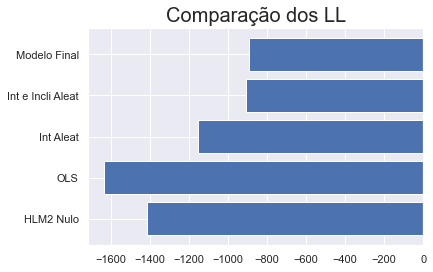

In [40]:
#Grafico de comparação dos LLs
a = ['HLM2 Nulo','OLS','Int Aleat','Int e Incli Aleat','Modelo Final']
b = [modelo_nulo.llf,modelo_OLS.llf,mod_interc_aleat.llf,inter_incli_aleat.llf,inter_aleat_final.llf]
plt.barh(a,b);
plt.title('Comparação dos LL',size=20);

**Podemos observar que o LL do modelo Final com a variável 'texp' e o modelo com Intercepto e Inclinações Aleatórias obtiveram os melhores LL**

In [41]:
#Verificar se os LL do modelo final e do modelo Int e Incli Aleat são estatisticamente diferentes de 0
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

def lrtest(llmin, llmax):
    lr = 2 * (llmax - llmin)
    p = stats.chisqprob(lr, 1) # llmax has 1 dof more than llmin
    return lr, p

lr, p = lrtest(inter_incli_aleat.llf, inter_aleat_final.llf)
print(f'P_valor: {round(p,4)}')

P_valor: 0.0


**p_value < 0.05, rejeita a hipótese nula, os loglikes dos 2 modelos não são estatisticamente iguais, portanto o modelo final apresentou o melhor LL, consequentemente o melhor modelo**

## Visualização dos interceptos e das inclinações aleatórios por escola

In [42]:
#Valores dos Intercepto e inclinação do nivel 2
int_incli = pd.DataFrame(inter_aleat_final.random_effects).T
int_incli.columns = ['Intercepto_Escola','Inclinação_HorasdeEstudo']
int_incli['escola'] = dados.escola.unique()
int_incli = int_incli.set_index('escola')
int_incli

,Intercepto_Escola,Inclinação_HorasdeEstudo
escola,,
1,-0.211364,0.438811
2,1.291495,-0.278181
3,6.090772,-0.779130
4,-5.245506,0.450368
5,-1.695358,-0.139678
6,3.864292,0.005096
7,-8.270892,0.909171
8,-1.363471,0.217166
9,3.705674,-0.607100


**Intercepto da Escola e o valor da inclinação a cada incremento de 1 unidade de estudo**

**As escola 2, 3, 5, 9 e 10 tem um decréscimo a medida que se avança a quantidade de horas de estudo**

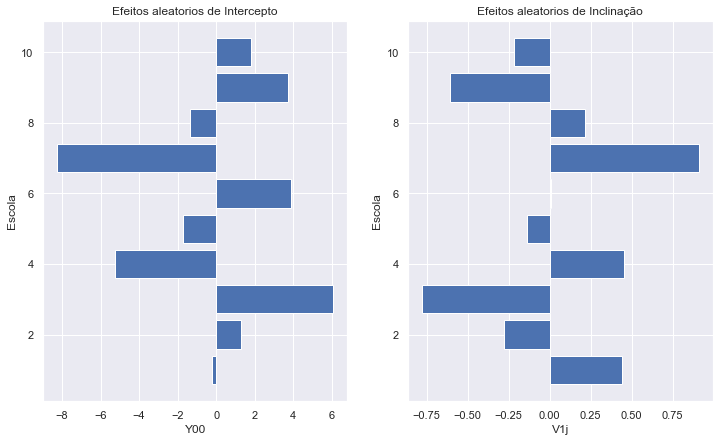

In [43]:
#Verificar graficamente os efeitos aleatorios nos dados

#Efeito de aleatorio de intercepto
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,7))
a = np.arange(len(int_incli))+1
b = int_incli.Intercepto_Escola
ax1.barh(a,b);
ax1.set(title="Efeitos aleatorios de Intercepto", xlabel="Y00", ylabel="Escola")
plt.gca().invert_yaxis()

#Efeito de aleatorio de Inclinação
a1 = np.arange(len(int_incli))+1
b1 = int_incli.Inclinação_HorasdeEstudo
ax2.barh(a1,b1);
ax2.set(title="Efeitos aleatorios de Inclinação", xlabel="V1j", ylabel="Escola")

plt.gca().invert_yaxis()

**Podemos interpretar os efeitos aleatórios de intercepto do nível 2 como o intercepto da regressão linear, porem neste caso cada escola terá um intercepto diferente, o parâmetro da inclinação segue o mesmo raciocínio**

# Previsão

In [44]:
#Previsão efeitos fixos
dados['predict_efeito_fixo'] = inter_aleat_final.predict(exog=x)

#Previsão efeitos aleatorios
dados['Predict_efeito_Aleatorio'] = inter_aleat_final.fittedvalues

dados

,escola,desempenho,horas,texp,predict_efeito_fixo,Predict_efeito_Aleatorio
estudante,,,,,,
1,1,25.0,11,3.6,21.885819,26.501371
2,1,52.0,23,3.6,40.462363,50.343641
3,1,52.0,25,3.6,43.558453,54.317353
4,1,30.0,14,3.6,26.529955,32.461938
5,1,51.0,24,3.6,42.010408,52.330497
...,...,...,...,...,...,...
354,10,46.5,28,3.9,50.625529,46.397262
355,10,21.0,9,3.9,19.891243,19.776900
356,10,42.0,27,3.9,49.007935,44.996191


**Observamos que usando efeitos aleatórios na predição, o modelo fica bem próximo dos dados reais**

## Mátricas para avaliar os modelos

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse_fixo = mean_squared_error(y,dados.predict_efeito_fixo)
mse_aleat = mean_squared_error(y,dados.Predict_efeito_Aleatorio)

mae_fixo = mean_absolute_error(y,dados.predict_efeito_fixo)
mae_aleat = mean_absolute_error(y,dados.Predict_efeito_Aleatorio)

print(f'mean_squared_error:')
print(f'mse_fixo: {mse_fixo}')
print(f'mse_aleat: {mse_aleat}')

print(f'\nmean_absolute_error:')
print(f'mae_fixo: {mae_fixo}')
print(f'mae_aleat: {mae_aleat}')

mean_squared_error:
mse_fixo: 48.74335943665086
mse_aleat: 6.686243581932303

mean_absolute_error:
mae_fixo: 5.768255023000684
mae_aleat: 2.2121267449280024


**Observe que o valor de ambas as métricas o modelo com efeito aleatório o resultado é melhor**

## Previsão sem o uso do algoritimo 

### Prever a observação da linha 0

In [46]:
linha_zero = dados[['escola','horas','texp']]
linha_zero = linha_zero.head(1)
linha_zero['Target'] = dados.iloc[0,1]
linha_zero

,escola,horas,texp,Target
estudante,,,,
1,1,11,3.6,25.0


**Prever a observação do estudante 1**

### Parâmetros Efeitos Fixos

In [47]:
#Atribuindo os parametros nas variaveis
intercepto_fixed = inter_aleat_final.params.Intercept
horas_fixed = inter_aleat_final.params.horas
texp_fixed = inter_aleat_final.params.texp
texp_horas_fixed = inter_aleat_final.params[3]

print(f'intercepto_fixed: {intercepto_fixed}')
print(f'horas_fixed: {horas_fixed}')
print(f'texp_fixed: {texp_fixed}')
print(f'texp_horas_fixed {texp_horas_fixed}')

intercepto_fixed: -0.8496025656429276
horas_fixed: 0.713461103873354
texp_fixed: 1.5852563538779625
texp_horas_fixed 0.2318289476392198


### Previsão: Parametros Fixos

In [48]:
#Variaveis Preditoras
escola = linha_zero.iloc[0,0]
horas = linha_zero.iloc[0,1]
texp = linha_zero.iloc[0,2]

#Previsão Parametros Fixos
fixed = intercepto_fixed + horas_fixed*horas + texp_fixed*texp + texp_horas_fixed*(texp*horas)
linha_zero['Prev_fixed'] = fixed
linha_zero

,escola,horas,texp,Target,Prev_fixed
estudante,,,,,
1,1,11,3.6,25.0,21.885819


**Previsão usando somente os parâmetros de efeitos fixos**

## Previsão: Parâmetros Fixos + Aleatórios

### Parâmetros Efeitos Aleatórios

In [49]:
#Tabela com os parametros de efeito aleatorios
parans_aleat = pd.DataFrame(inter_aleat_final.random_effects)

#Atribuindo os parametros nas variaveis
intercepto_alet = parans_aleat.iloc[0,0]
inclinacao_alet = parans_aleat.iloc[1,0]

print(f'intercepto_alet: {intercepto_alet}')
print(f'inclinacao_alet: {inclinacao_alet}')


intercepto_alet: -0.21136442177525439
inclinacao_alet: 0.4388105800485731


### Previsão: Parâmetros Fixos + Aleatórios

In [50]:
#Variaveis Preditoras
horas = linha_zero.iloc[0,1]

#Previsão
fixed_alet = fixed + intercepto_alet + inclinacao_alet*horas
linha_zero['fixed+aleat'] = fixed_alet
linha_zero

,escola,horas,texp,Target,Prev_fixed,fixed+aleat
estudante,,,,,,
1,1,11,3.6,25.0,21.885819,26.501371


**Previsão usando efeitos fixos + aleatorios**

# Comparar as Previsões com os Efeitos Fixos e Efeitos Fixos + Aleatórios

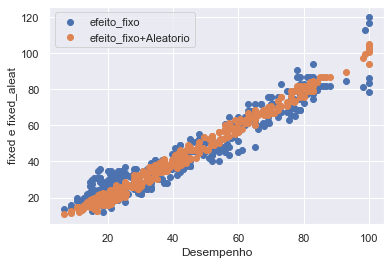

In [51]:
plt.scatter(dados.desempenho,dados['predict_efeito_fixo']);
plt.scatter(dados.desempenho,dados['Predict_efeito_Aleatorio']);
plt.xlabel('Desempenho');
plt.ylabel('fixed e fixed_aleat');

plt.legend(['efeito_fixo','efeito_fixo+Aleatorio'])

**Note que o ajuste do modelo com efeitos fixo + aleatório teve pouca dispersão em relação ao modelo somente com efeitos fixos**

# Modelo OLS com Dummies

In [52]:
#Transformar a variável escola em dummie
Dummies = pd.get_dummies(dados['escola'])

#Excluir a 1 variaveis para que ela seja a variável de referencia do modelo
Dummies = Dummies.iloc[:,1:10]
Dummies

,2,3,4,5,6,7,8,9,10
estudante,,,,,,,,,
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
354,0,0,0,0,0,0,0,0,1
355,0,0,0,0,0,0,0,0,1
356,0,0,0,0,0,0,0,0,1


In [53]:
#Juntar os dataframes - Variáveis X
x1 = x[['horas','texp']]
dados1 = x1.join(Dummies)
dados1.head(3)

,horas,texp,2,3,4,5,6,7,8,9,10
estudante,,,,,,,,,,,
1,11,3.6,0,0,0,0,0,0,0,0,0
2,23,3.6,0,0,0,0,0,0,0,0,0
3,25,3.6,0,0,0,0,0,0,0,0,0


In [54]:
#Modelo OLS
import statsmodels.api as sm

#Add constante 
x_constante = sm.add_constant(dados1)

#Variável Y
y = dados['desempenho'].values

#Criar modelo
modelo = sm.OLS(y,x_constante)
modelo_v1 = modelo.fit()
modelo_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     575.7
Date:                Fri, 22 Jul 2022   Prob (F-statistic):          2.81e-209
Time:                        09:28:42   Log-Likelihood:                -1120.2
No. Observations:                 358   AIC:                             2262.
Df Residuals:                     347   BIC:                             2305.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.0528      1.352     -8.175      0.000     -13.712      -8.394
horas          1.9713      0.056     35.063      0.000       1.861       2.082
texp           4.4516      0.096     46.582      0.000       4.264       4.640
2            -14.6664      1.452    -10.101      0.000     -17.522     -11.811
3             -7.2914      0.685    -10.651      0.000      -8.638      -5.945
4             -0.7854      1.443     -0.544      0.587      -3.624       2.053
5            -14.8095      1.238    -11.967      0.000     -17.244     -12.375
6             -3.3658      1.321     -2.548      0.011      -5.964      -0.768
7              2.3462      1.115      2.103      0.036       0.152       4.540
8              4.5433      1.130      4.021      0.000       2.321       6.766
9            -24.6820      1.323    -18.657      0.000     -27.284     -22.080
10           -11.9232      1.310     -9.099      0.000     -14.501      -9.346
==============================================================================
Omnibus:                       14.171   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               32.665
Skew:                           0.002   Prob(JB):                     8.07e-08
Kurtosis:                       4.480   Cond. No.                     1.09e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.28e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Note que a variável dummie de número 4, não é estatisticamente significante, vamos fazer o processo de step-wise para selecionar as variáveis relevantes para o modelo**

In [55]:
#Processo Step-Wise
import warnings
warnings.filterwarnings('ignore')

def stepwise_selection(X, y, 
                           initial_list=[], 
                           threshold_in=0.01, 
                           threshold_out = 0.05, 
                           verbose=True):
        """ Perform a forward-backward feature selection 
        based on p-value from statsmodels.api.OLS
        Arguments:
            X - pandas.DataFrame with candidate features
            y - list-like with the target
            initial_list - list of features to start with (column names of X)
            threshold_in - include a feature if its p-value < threshold_in
            threshold_out - exclude a feature if its p-value > threshold_out
            verbose - whether to print the sequence of inclusions and exclusions
        Returns: list of selected features 
        Always set threshold_in < threshold_out to avoid infinite looping.
        See https://en.wikipedia.org/wiki/Stepwise_regression for the details
        """
        included = list(initial_list)
        while True:
            changed=False
            # forward step
            excluded = list(set(X.columns)-set(included))
            new_pval = pd.Series(index=excluded)
            for new_column in excluded:
                model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
                new_pval[new_column] = model.pvalues[new_column]
            best_pval = new_pval.min()
            if best_pval < threshold_in:
                best_feature = new_pval.idxmin()
                included.append(best_feature)
                changed=True
                if verbose:
                    print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

            # backward step
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
            # use all coefs except intercept
            pvalues = model.pvalues.iloc[1:]
            worst_pval = pvalues.max() # null if pvalues is empty
            if worst_pval > threshold_out:
                changed=True
                worst_feature = pvalues.idxmax()
                included.remove(worst_feature)
                if verbose:
                    print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
            if not changed:
                break
        return included

result = stepwise_selection(x_constante, y)

#Variáveis que demonstraram ser estatisticamente significantes para o modelo OLS
print(f'\nVariáveis Significantes para modelagem: {result}')

Add  const                          with p-value 1.77917e-113
Add  texp                           with p-value 2.00108e-66
Add  horas                          with p-value 2.41038e-71
Add                               3 with p-value 7.0592e-42
Add                               9 with p-value 5.25954e-21
Add                              10 with p-value 3.96859e-07
Add                               5 with p-value 1.96925e-08
Add                               2 with p-value 1.63638e-14

Variáveis Significantes para modelagem: ['const', 'texp', 'horas', 3, 9, 10, 5, 2]


In [56]:
#Selecionar as veriáveis que demonstraram ser estatisticamente significantes para o modelo OLS
dados_2 = x_constante[result]


In [57]:
#Modelo OLS (excluida variavel de escola 10)
import statsmodels.api as sm
x_constante = sm.add_constant(dados_2)
y = dados['desempenho'].values
modelo5 = sm.OLS(y,x_constante)
modelo_OLS1 = modelo5.fit()
modelo_OLS1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     802.3
Date:                Fri, 22 Jul 2022   Prob (F-statistic):          3.12e-211
Time:                        09:28:42   Log-Likelihood:                -1125.8
No. Observations:                 358   AIC:                             2268.
Df Residuals:                     350   BIC:                             2299.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.8732      1.512    -11.161      0.000     -19.846     -13.900
texp           5.5727      0.234     23.865      0.000       5.113       6.032
horas          1.9935      0.053     37.803      0.000       1.890       2.097
3            -16.3567      2.059     -7.944      0.000     -20.406     -12.307
9            -21.5080      1.322    -16.272      0.000     -24.108     -18.908
10           -10.9732      1.171     -9.368      0.000     -13.277      -8.669
5            -11.5323      1.245     -9.266      0.000     -13.980      -9.084
2            -11.6258      1.450     -8.017      0.000     -14.478      -8.774
==============================================================================
Omnibus:                       13.805   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               25.182
Skew:                          -0.201   Prob(JB):                     3.40e-06
Kurtosis:                       4.235   Cond. No.                         188.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Note que todas as variáveis agora tem significância estatística**

## COMPARAÇÃO DOS LOGLIKES ENTRE OS MODELOS

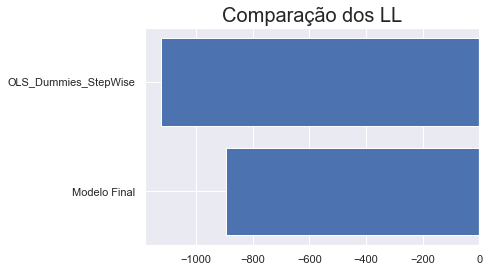

In [58]:
a = ['Modelo Final','OLS_Dummies_StepWise']
b = [inter_aleat_final.llf,modelo_OLS1.llf]
plt.barh(a,b);
plt.title('Comparação dos LL',size=20);

## Conclusão:

**Modelo OLS X Modelo Multinível tem uma grande diferença no LL, porém, caso o efeito aleatório de inclinação no nível 2 do modelo multinível não se mostra-se estatisticamente significantes o LL dos 2 modelos será muito parecido**

## Gráfico dos fitted values dos modelos HLM2 Final contra OLS

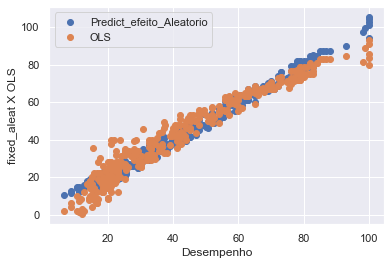

In [59]:
#Gráficos
plt.scatter(dados.desempenho,dados['Predict_efeito_Aleatorio']);
plt.scatter(dados.desempenho,modelo_OLS1.predict(dados_2));
plt.xlabel('Desempenho');
plt.ylabel('fixed_aleat X OLS')
plt.legend(['Predict_efeito_Aleatorio','OLS']);

**A dispersão nos dados no modelo OLS é maior que no modelo multinivel**

# Modelo OLS com dummies + Interação entre as variáveis Horas e texp

In [60]:
#Dados
dados3=dados1.copy()
dados3['texp_horas'] = dados1.texp*dados1.horas #Interaçao entre as variaveis horas e texp
dados3

,horas,texp,2,3,4,5,6,7,8,9,10,texp_horas
estudante,,,,,,,,,,,,
1,11,3.6,0,0,0,0,0,0,0,0,0,39.6
2,23,3.6,0,0,0,0,0,0,0,0,0,82.8
3,25,3.6,0,0,0,0,0,0,0,0,0,90.0
4,14,3.6,0,0,0,0,0,0,0,0,0,50.4
5,24,3.6,0,0,0,0,0,0,0,0,0,86.4
...,...,...,...,...,...,...,...,...,...,...,...,...
354,28,3.9,0,0,0,0,0,0,0,0,1,109.2
355,9,3.9,0,0,0,0,0,0,0,0,1,35.1
356,27,3.9,0,0,0,0,0,0,0,0,1,105.3


In [61]:
#Step_Wise
result2 = stepwise_selection(dados3, y)

#Variáveis que demonstraram ser estatisticamente significantes para o modelo OLS
print(f'\nVariáveis Significantes para modelagem: {result}')

Add  texp_horas                     with p-value 1.59279e-198
Add                               9 with p-value 1.2549e-14
Add                               3 with p-value 1.18638e-14
Add                               5 with p-value 7.71654e-11
Add                               2 with p-value 1.21965e-09
Add                              10 with p-value 3.83313e-12
Add  horas                          with p-value 1.24343e-18
Drop                              3 with p-value 0.0696652
Add                               7 with p-value 2.73072e-08
Add                               6 with p-value 6.46773e-05

Variáveis Significantes para modelagem: ['const', 'texp', 'horas', 3, 9, 10, 5, 2]


In [62]:
#Selecionar as veriáveis que demonstraram ser estatisticamente significantes para o modelo OLS
dados_3 = dados3[result2]

In [63]:
#Modelo OLS
import statsmodels.api as sm
x_constante = sm.add_constant(dados_3)
y = dados['desempenho'].values
modelo6 = sm.OLS(y,x_constante)
modelo_OLS2 = modelo6.fit()
modelo_OLS2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1532.
Date:                Fri, 22 Jul 2022   Prob (F-statistic):          1.25e-266
Time:                        09:28:43   Log-Likelihood:                -991.43
No. Observations:                 358   AIC:                             2001.
Df Residuals:                     349   BIC:                             2036.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4020      0.753     15.141      0.000       9.921      12.883
texp_horas     0.2512      0.005     48.818      0.000       0.241       0.261
9            -20.0187      0.911    -21.981      0.000     -21.810     -18.228
5            -13.8749      0.834    -16.628      0.000     -15.516     -12.234
2            -13.3578      0.989    -13.509      0.000     -15.303     -11.413
10           -10.2847      0.841    -12.222      0.000     -11.940      -8.630
horas          0.6915      0.042     16.418      0.000       0.609       0.774
7              4.1687      0.810      5.148      0.000       2.576       5.761
6             -3.5032      0.866     -4.044      0.000      -5.207      -1.799
==============================================================================
Omnibus:                       29.891   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.235
Skew:                          -0.432   Prob(JB):                     4.14e-15
Kurtosis:                       4.922   Cond. No.                         830.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Todas as variáveis tem significância estatística**

## COMPARAÇÃO DOS LLs DE TODOS OS MODELOS 

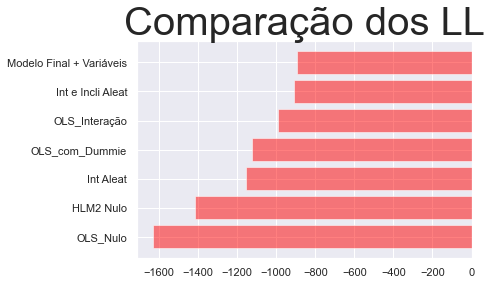

In [64]:
#Criar um dataFrame com os LLs
a = ['HLM2 Nulo','OLS_Nulo','Int Aleat','Int e Incli Aleat','Modelo Final + Variáveis','OLS_com_Dummie','OLS_Interação']
b = [modelo_nulo.llf,modelo_OLS.llf,mod_interc_aleat.llf,inter_incli_aleat.llf,inter_aleat_final.llf,
     modelo_OLS1.llf,modelo_OLS2.llf]
dados_grafico = pd.DataFrame(a,b)
dados_grafico= dados_grafico.reset_index()
dados_grafico.columns=['Index','Modelo']

#Plotar no Grafico 
df_ordenado = dados_grafico.sort_values(by='Index',ascending=True)
plt.barh(df_ordenado.Modelo, df_ordenado.Index, color='red', alpha=0.5)
plt.title('Comparação dos LL',size=40,);

In [65]:
#Tabela com todos os valores do LL
tab = pd.DataFrame(b,a,columns=['LL'])
pd.DataFrame(tab.LL.sort_values(ascending=False))

,LL
Modelo Final + Variáveis,-894.568408
Int e Incli Aleat,-906.802752
OLS_Interação,-991.431454
OLS_com_Dummie,-1125.849437
Int Aleat,-1155.246640
HLM2 Nulo,-1416.007393
OLS_Nulo,-1633.485197


**Podemos observar que o Modelo Final tem o melhor LL**

## Conclusão:

**Os Modelos Multiníveis levam em consideração uma estrutura aninhada para os dados, combinando informações de variáveis de diferentes níveis, e reduzindo perda de informações, caso as variáveis se mostrem estatisticamente significantes para o modelo, dificilmente outro modelo conseguirá obter uma métrica melhor**